Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

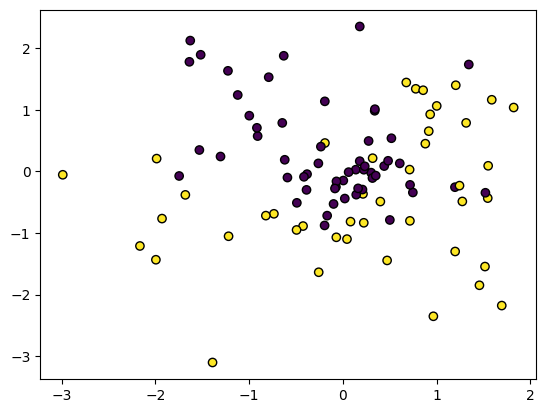

In [ ]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [ ]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]),
                         X, X.pow(2), interactions), -1)

print("Dimension of Phi, `features_simple`:", features_simple(X_train).shape)
print("Dimension of Phi, `features_quadratic`:", features_quadratic(X_train).shape)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
Dimension of Phi, `features_quadratic`: torch.Size([100, 6])


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [ ]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [ ]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar

    """

    # YOUR CODE HERE

    # log of likelihood, log p(y|Phi, w)
    y_hat = torch.sigmoid(Phi @ w)
    log_likelihood_probs = dist.Bernoulli(y_hat).log_prob(y).sum()

    # log of prior probabilities of weights, P(w)
    log_prior_probs = dist.Normal(0, sigma).log_prob(w).sum()


    # log of joint probabilities
    log_joint = log_prior_probs + log_likelihood_probs

    return log_joint

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [ ]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []

    # YOUR CODE HERE

    # number of iterations
    N_steps=5000

    # learning rate for the optimizer
    learning_rate=0.01

    # tolerance for the stopping criteria
    tol=1e-5

    # define an optimizer
    optimizer = torch.optim.SGD((weights,), lr=learning_rate, momentum=0.01)

    for i in range(N_steps):
        optimizer.zero_grad()

        # perform forward pass
        neg_log_joint = -log_joint(Phi, y, weights)

        # Perform backward pass
        neg_log_joint.backward()

        # Update the weights
        optimizer.step()

        # Record the loss
        losses.append(neg_log_joint.item())

        # Check for convergence (if the change in loss is very small)
        if i > 0 and abs(losses[-2] - losses[-1]) < tol:
            break

    # Return the MAP estimate and the list of losses
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

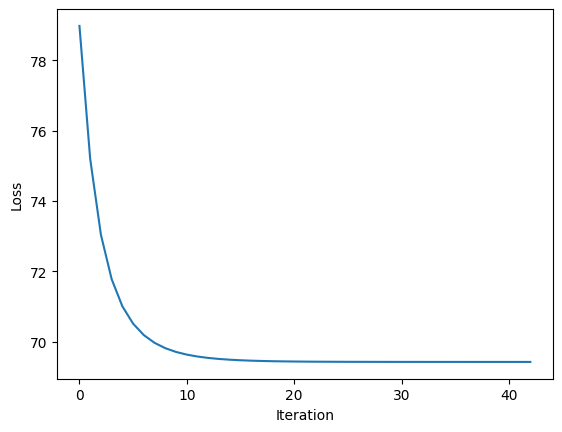

In [ ]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

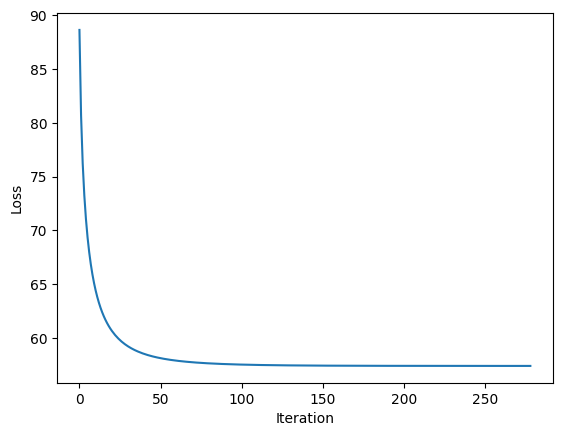

In [ ]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [ ]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')

    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');

    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


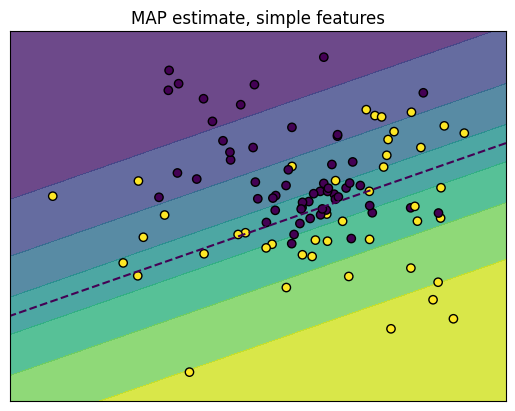

In [ ]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


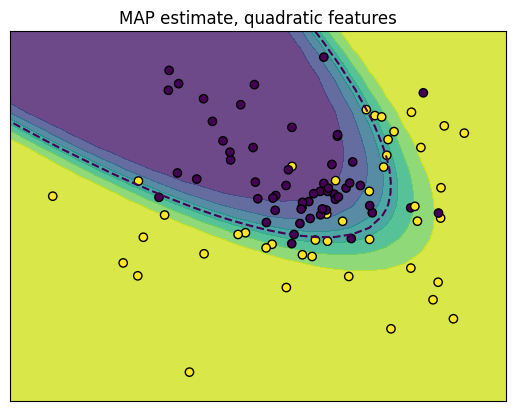

In [ ]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [ ]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance
    in a logistic regression setting.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace
          approximation
    """


    # YOUR CODE HERE

    # Get the dimension of Phi
    N, D = Phi.shape

    # Calculate the y_hat by using the predict_probs_MAP function above
    y_hat = predict_probs_MAP(Phi, w_MAP)

    # inverse of S_0
    S_0_inverse = torch.linalg.inv(torch.tensor(prior_std**2) * torch.eye(D))

    # initialize the total summation
    big_sigma_sum = 0

    # calculate the total sum (i.e. from 1 to N) which is the sigma summation part of the inverse covariance equation
    for i in range(N):
      big_sigma_sum += (y_hat[i] * (1-y_hat[i]))*(Phi[i].reshape(D,1) @ Phi[i].reshape(1,D))

    # get the inverse of covariance by adding the inverse of S_0 and the sigma summation  together
    Cov_inverse = S_0_inverse + big_sigma_sum

    # calculate the covariance S_N
    Cov = torch.linalg.inv(Cov_inverse)

    return Cov

In [ ]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior
    w ~ MultivariateNormal(w_MAP, Cov)

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """

    # YOUR CODE HERE

    # Simple Monte Carlo for making predictions, summation from 1 to L
    summation = 0
    L = 20000
    for i in range(L):
        weight = dist.MultivariateNormal(w_MAP,Cov).sample()
        summation += predict_probs_MAP(Phi, weight)

    y_hat = summation/L

    return y_hat

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [ ]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

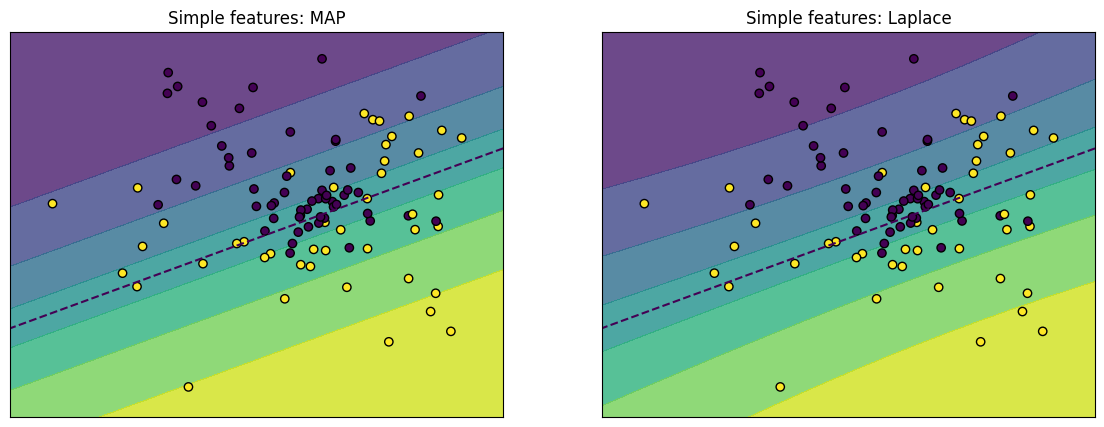

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [ ]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

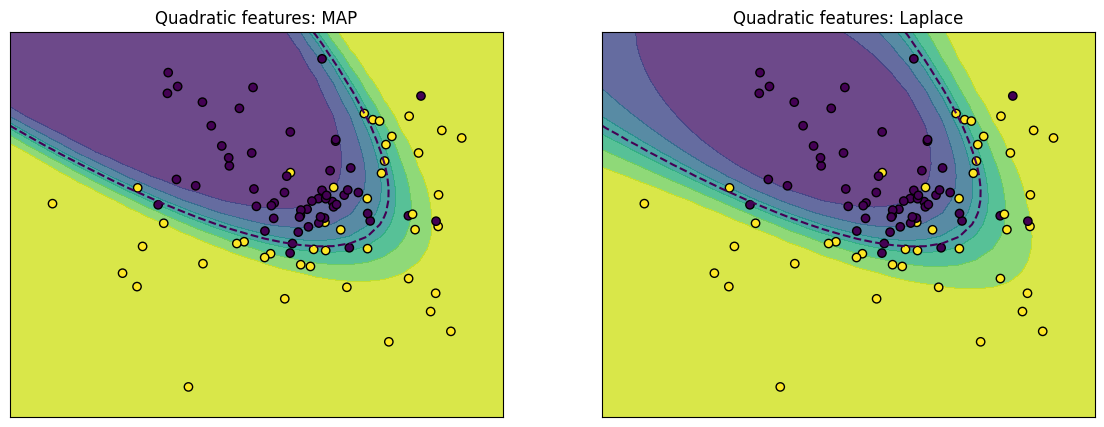

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

In [ ]:
 # (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [ ]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.

    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix

    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """

    # YOUR CODE HERE

    # Get the dimension of Phi
    N, D = Phi.shape

    # get the Occam Factor
    occam_factor = 0.5*D*(np.log(2*np.pi)) - 0.5*np.log(np.linalg.det(torch.linalg.inv(Cov)))

    log_evidence = log_joint(Phi,y,w_MAP) + occam_factor

    return log_evidence

In [ ]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.93241119384766
Model evidence estimate (polynomial features): -57.54474639892578


In [ ]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [ ]:
def features_student(X):
    """
    Compute your own, custom set of features!

    INPUT:
    X      : (N, 2) tensor of raw input data

    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """

    # YOUR CODE HERE

    N = X.shape[0]

    # Start with the bias term
    Phi = [torch.ones(N, 1)]

    # set the polynomial degree to 3
    degree = 3

    # Generate polynomial terms from degree=3 to 1 (i.e. X1^3, X1^2*X2, X1*X2^2, X2^3, X1^2, X1*X2, X2^2, X1, X2)
    for d in range(degree, 0, -1):
        for i in range(d + 1):
            term = (X[:, 0] ** (d - i)) * (X[:, 1] ** i)
            Phi.append(term.reshape(-1, 1))  # Reshape to ensure it is a 2D tensor

    # Concatenate all terms in the second dimension
    Phi = torch.cat(Phi, dim=1)
    return Phi

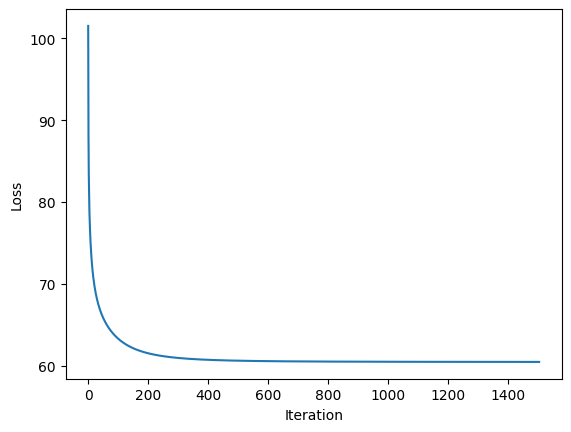

In [ ]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [ ]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))



YOUR features! Training accuracy = 0.89, test accuracy = 0.92


In [ ]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -55.54781723022461


In [ ]:
w_MAP_student

tensor([-3.1868, -0.8329, -0.5426, -1.4219, -2.6888,  1.2939,  3.0371,  3.8823,
         3.1608,  0.2744])

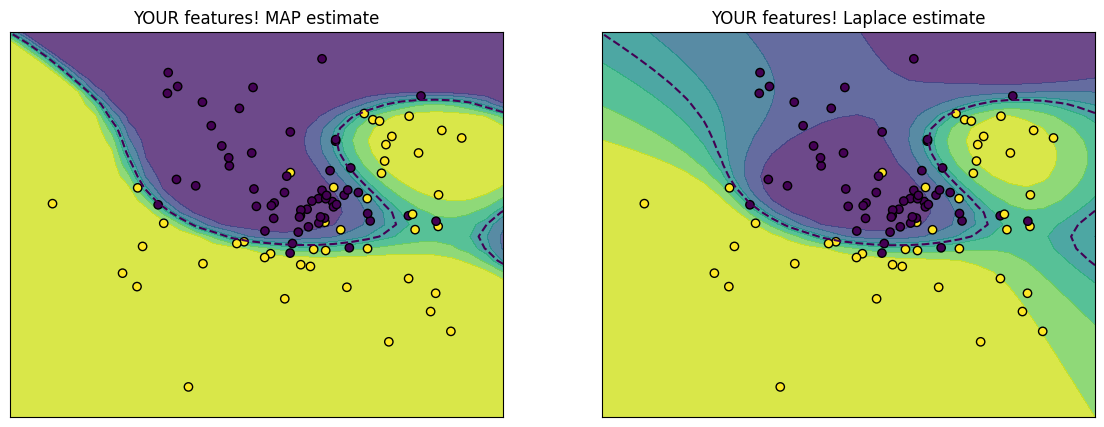

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train,
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?
2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

YOUR ANSWER HERE

Question 1:



*   Firstly, I choose to use cubic polynomial  feature functions as my custom feature space. In this case, the complexity and non-linear relationship between the input features and output targets are well-captured by this cubic polynomial. Particulalry, as shown in the diagnostic plot of loss versus number of iterations above, the loss curve decreases rapiadly in the begining of the training and then converges to a stable final loss value, which indicates that the model has a good achievement in terms of fitting the training data. Besides, a training accuracy of 0.89 and a test accuracy of 0.92 have been achieved by applying this cubic polynomial fucntions. Compared with the results of quadratic features (i.e. 0.86 training accuracy and 0.92 testing accuracy respectively), there is an improvement of 3% in the training accuracy by utilizing the cubic polynomial, which shows that my choice of feature space is appropriate and reasonable with enhanced performance. In addition, the cubic polynomial feature has a log model evidence of -55.54, whereas, the quadratic feature has a log model evidence of -57.54. This reveals that the cubic polynomial has a slightly higher model evidence and can therefore "better" capture the "important" patterns of data with a more complex model than quadratic features.

*   As for the methods of comparing different sets of features, one of the metrics can be used here is the model evidence: $$posterior=\frac{likelihood×prior}{evidence}=\frac{p(D|θ,M)p(θ|M)}{p(D|M)}$$ where we can use the evidence term (also called marginal likelihood), $p(D|M)=\displaystyle∫p(D,θ|M)dθ$, to assesse the probability of the data with parameters marginalized out for our model selection. Suppose there are two models $M_0$ and $M_1$, one can compare them by respectively computing: $$p(M_0|D)=\frac{p(D|M_0)p(M_0)}{\sum^{1}_{i=0}p(D|M_i)p(M_i)}$$ $$$$ $$p(M_1|D)=\frac{p(D|M_1)p(M_1)}{\sum^{1}_{i=0}p(D|M_i)p(M_i)}$$ Then, a higher log evidence value will indicate a "better" model which captures the relevant patterns in the data effectively.

*   Another way of comparing features is by directly evluating the diagnostic plot of test errors and test accuracy where a relatively lower error and higer accuracy can indicate that the choice of feature sets is "better" than another. For example, the comparison results between the simple feature and the quadratic feature in terms of training/testing accuracy and final loss values shown above could be used as a good metric of the performance for different feature sets. Furthermore, by applying a K-Fold Cross-Validation is another effective way of comparing different feature sets. One can simply partition their dataset into k folds and hold out the fold as a validation set with the rest of k-1 folds to train the Bayesian classifier. Then, accuracy and log of loss can be obtained by evaluating the classifier on the held-out fold.

*   Speaking of the "ranking" of different features, these comparison metrics generally not always create the same ranking for different features. For example, the method of model evidence estimate take into account both the fitness of the data and the model complexity. Whereas, a feature set achieves high predictive accuracy under the K-Fold Cross-Validation may not necessarily has good "rankings" under the model evidence estimation. Therefore, different metrics focus on different aspects of defining "high-ranking" feature sets, and one should always consider multiple metrics when it comes to features selection.$$$$



Question 2:



*   I think overfitting is possible in my settings, especially, when it comes to higher-order of polynomial features. This happens when the model "learns/fits" the noise in the training data and it will result in negative impacts on new/unseen/testing data.

*   I experienced it when it comes to the fourth or fifth power of polynomial features where there is a significant difference between training and test performance metrics. That being said, when the accuracy of the training set is much higher than the accuracy of the test set, this is a classic sign of overfitting. As shown in diagnostic plots of the fourth power polynomial features below, the training accuracy = 0.89, test accuracy = 0.86, which indicates potentially an overfitting trend. Also, the model evidence estimate of this fourth polynomial is -66.25 which is much lower than -55.54 of my original selected cubic polynomial features. This reveals that this fourth-order polynomial feature may be too complex for our dataset and an overfitting issue is verly likely to happen when we continuously increase the orders for polynomial features. Given that, it can be concluded that a cubic polynomial feature looks more promising in our case. The simple linear features are "too simple" and the fourth/fifth-order polynomial features are "too complex" for us. In general, one would prefer simple models over the complex models, when either would suffice.

*   Finally, I think the method of Laplace approximation can be helpful with overfitting but only in a limited level. Since Laplace approximation can introduce a form of Occam's razor and act as a regularizer for penalizing model complexity, it helps to mitigate overfitting issues. For example, if we can compare the diffserence between MAP and Laplace estimates in terms of decision boundaries in the diagnostic plot below. To some extent, the Laplace estimate has relatively a "smoother" boundary than the MAP one especially on the top left part of the figure (Although they both show potentials to be overfitting). However, if the data itself is inevitably too complex, the problems of overfitting may still happen and one should therefore consider multiple methods, like cross-validation and feature selection techniques etc., to avoid overfitting issues accordingly.


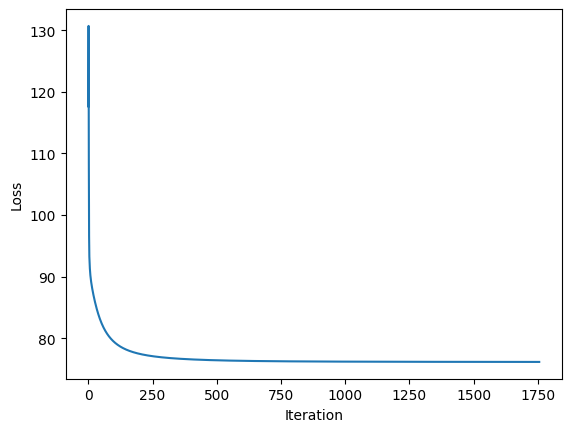

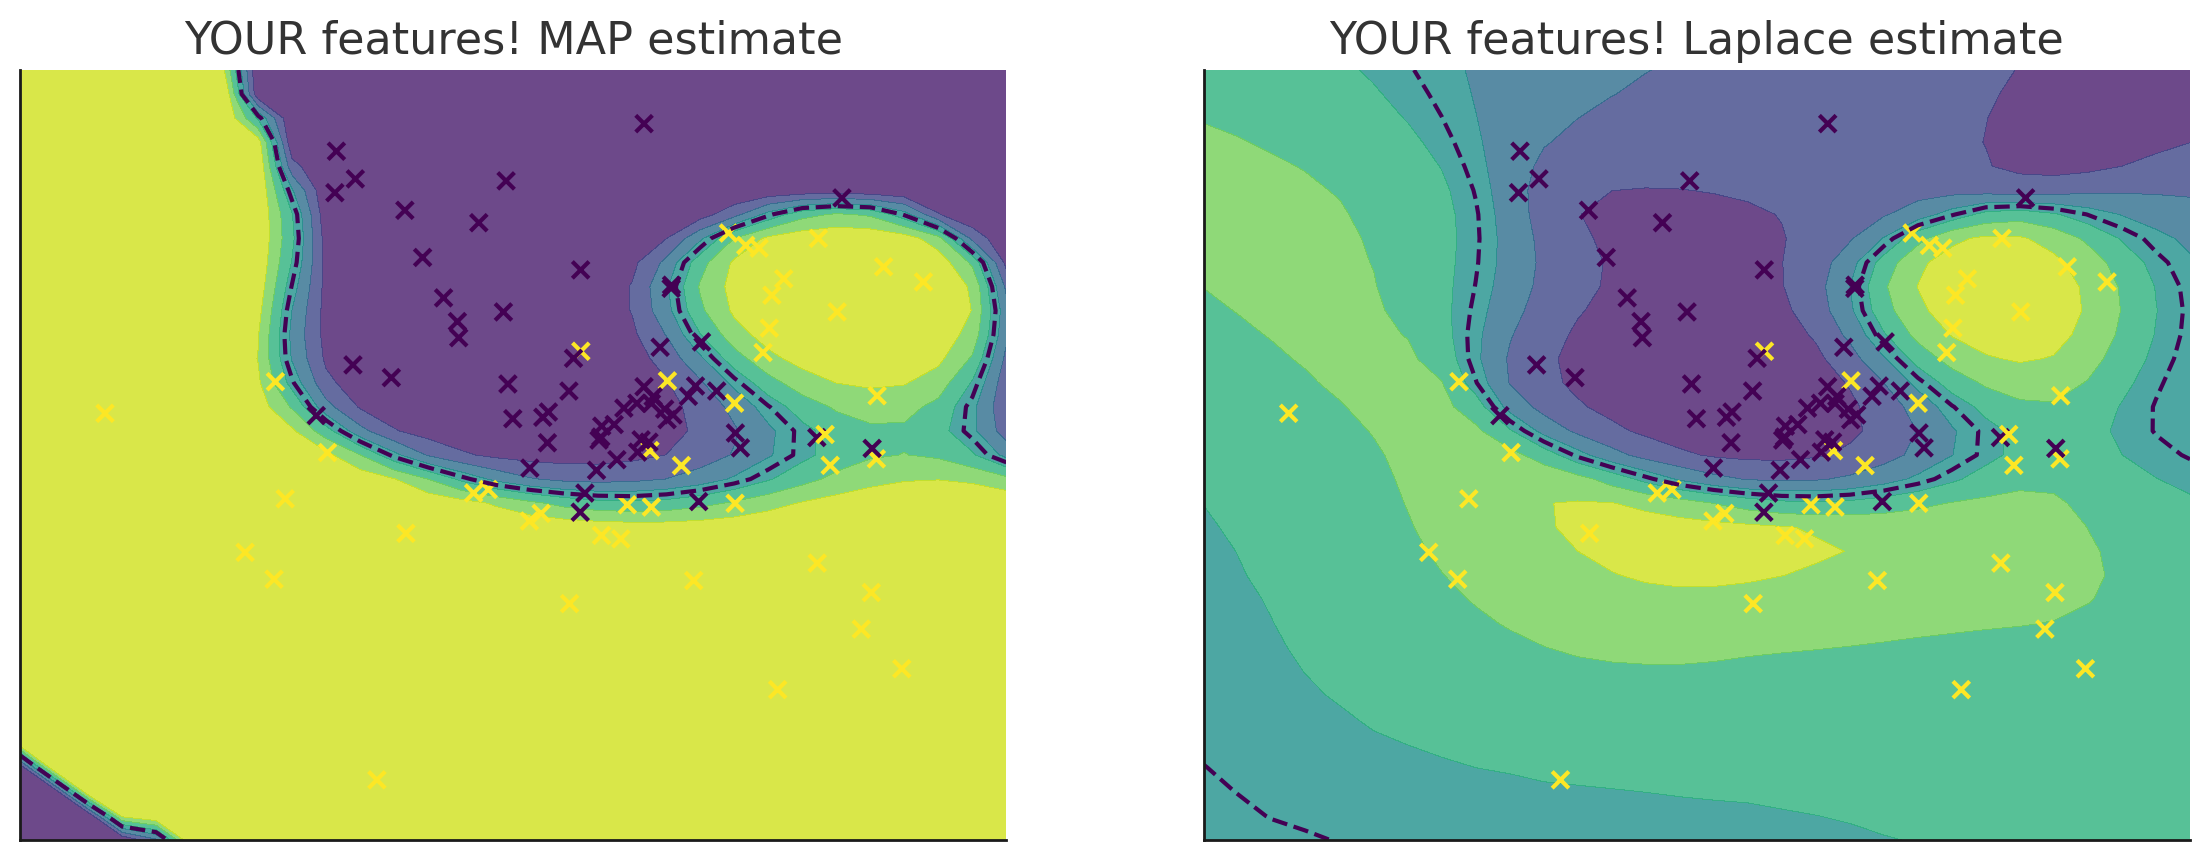

#### Ignore the following cells. They are used by the grading system.

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)